In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time

In [5]:
 df=pd.read_csv("train.csv",header=0, index_col=0, parse_dates=True)

In [6]:
df.head()

,store,product,number_sold
Date,,,
2010-01-01,0,0,801
2010-01-02,0,0,810
2010-01-03,0,0,818
2010-01-04,0,0,796
2010-01-05,0,0,808


In [4]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.tsaplots import plot_pacf

In [8]:
df.drop(columns=["store","product"],inplace=True)

In [9]:
df.head()

,number_sold
Date,
2010-01-01,801
2010-01-02,810
2010-01-03,818
2010-01-04,796
2010-01-05,808


In [10]:
df.tail()

,number_sold
Date,
2018-12-27,890
2018-12-28,892
2018-12-29,895
2018-12-30,899
2018-12-31,912


In [12]:
df.shape

(230090, 1)

In [14]:
df.describe()

,number_sold
count,230090.000000
mean,780.926107
std,204.096737
min,238.000000
25%,722.000000
50%,835.000000
75%,914.000000
max,1205.000000


In [25]:
df=df.resample("M").sum()
df

,number_sold
Date,
2010-01-31,1698403
2010-02-28,1529750
2010-03-31,1688388
2010-04-30,1630998
2010-05-31,1685240
...,...
2018-08-31,1709901
2018-09-30,1660685
2018-10-31,1717400


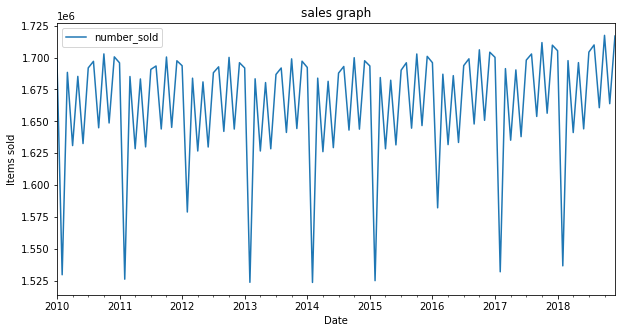

In [26]:
df.plot(figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Items sold")
plt.title("sales graph")
plt.show()

this dataset has seasonality

### seasonal decompose

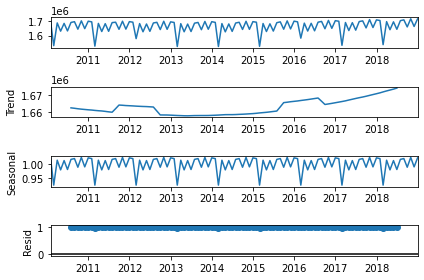

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

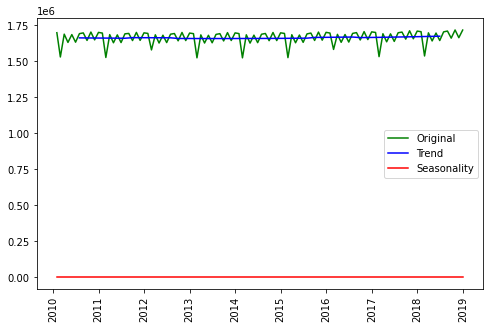

In [28]:
decom = seasonal_decompose(df,model='multiplicative')

observed = decom.observed
trend = decom.trend
seasonal = decom.seasonal
residual = decom.resid

plt.figure(figsize=(8,5))
plt.plot(observed,color='green',label='Original')
plt.plot(trend,color='blue',label='Trend')
plt.plot(seasonal,color='red',label='Seasonality')
# plt.plot(residual,color='black',label='Residual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### stationarity check

In [29]:
from statsmodels.tsa.stattools import adfuller

In [30]:
def adf_test(data):
    res = adfuller(data)
    print('ADF Statistic:',res[0])
    print('p-value:',res[1])
    if res[1]>0.05:
        print('Ho accpeted - Data is not stationary')
    else:
        print('H1 accpeted - Data is stationary')    

In [31]:
adf_test(df)

ADF Statistic: 0.5343272139492666
p-value: 0.9858799331312136
Ho accpeted - Data is not stationary


In [32]:
def plot_roll_mean_std(data,ws):
    rolmean = data.rolling(ws).mean()
    rolstd = data.rolling(ws).std()
    plt.figure(figsize=(8,5))
    plt.plot(data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend()
    plt.title(f'Rolling Mean and Standard Deviation with window size {ws}')
    plt.show()

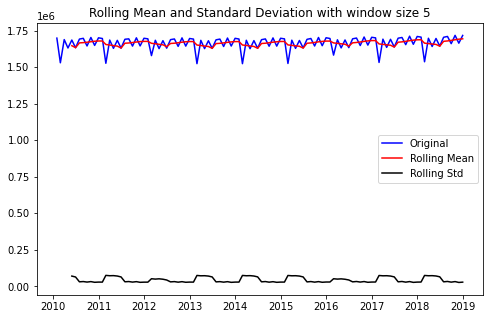

In [33]:
plot_roll_mean_std(df,5)

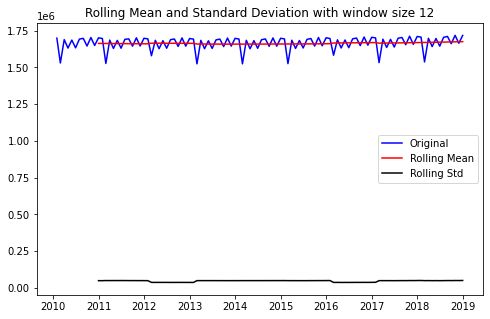

In [34]:
plot_roll_mean_std(df,12)

### converting non stationary data to stationary

ADF Statistic: -28.855441988661394
p-value: 0.0
H1 accpeted - Data is stationary


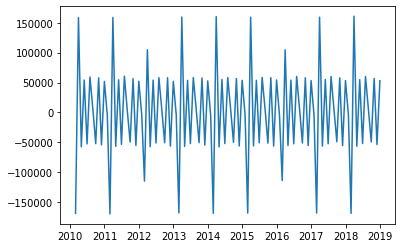

In [35]:
df_diff1 = df.diff(1).dropna() 
adf_test(df_diff1)
plt.plot(df_diff1)
plt.show()

### ACF AND PACF plot

In [36]:
def plot_acf_pacf(data,lag_val):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
    plot_acf(data,lags=lag_val,ax=ax1)
    ax1.set_title('Autocorrelation')

    plot_pacf(data,lags=lag_val,ax=ax2)
    ax2.set_title('Partial Autocorrelation')
    plt.show()

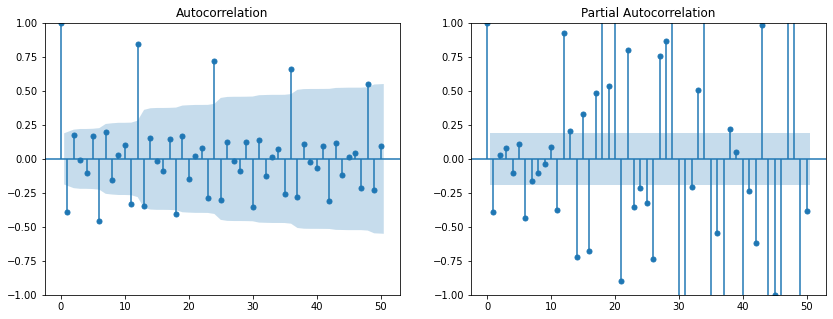

In [48]:
plot_acf_pacf(df,50)

### train test split

In [49]:
train= df[1:81]
test = df[81:108]
print(train.shape)
print(test.shape)

(80, 1)
(27, 1)


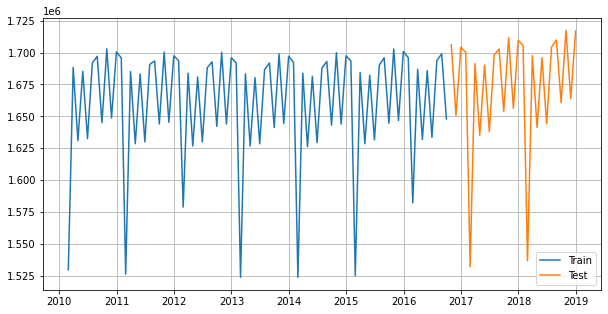

In [50]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.grid()
plt.legend()
plt.show()

In [51]:
print(train.tail(2))
print(test.head(2))
print(test.tail(2))

            number_sold
Date                   
2016-08-31      1699019
2016-09-30      1647918
            number_sold
Date                   
2016-10-31      1706075
2016-11-30      1650782
            number_sold
Date                   
2018-11-30      1663840
2018-12-31      1716870


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

### base AR model(1,0,0)

In [53]:
from statsmodels.tsa.arima.model import ARIMA

In [54]:
m1 = ARIMA(train,order=(1,0,0))
ar_m1 = m1.fit()
print(ar_m1.summary())

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                   80
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -964.837
Date:                Fri, 30 Dec 2022   AIC                           1935.674
Time:                        16:42:04   BIC                           1942.820
Sample:                    02-28-2010   HQIC                          1938.539
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.66e+06   3520.335    471.583      0.000    1.65e+06    1.67e+06
ar.L1         -0.4292      0.112     -3.815      0.000      -0.650      -0.209
sigma2      1.581e+09      0.032   4.98e+10      0.0

In [55]:
fcast_m1 = ar_m1.forecast(27)
fcast_m1

2016-10-31    1.665369e+06
2016-11-30    1.657880e+06
2016-12-31    1.661094e+06
2017-01-31    1.659715e+06
2017-02-28    1.660307e+06
2017-03-31    1.660053e+06
2017-04-30    1.660162e+06
2017-05-31    1.660115e+06
2017-06-30    1.660135e+06
2017-07-31    1.660126e+06
2017-08-31    1.660130e+06
2017-09-30    1.660128e+06
2017-10-31    1.660129e+06
2017-11-30    1.660129e+06
2017-12-31    1.660129e+06
2018-01-31    1.660129e+06
2018-02-28    1.660129e+06
2018-03-31    1.660129e+06
2018-04-30    1.660129e+06
2018-05-31    1.660129e+06
2018-06-30    1.660129e+06
2018-07-31    1.660129e+06
2018-08-31    1.660129e+06
2018-09-30    1.660129e+06
2018-10-31    1.660129e+06
2018-11-30    1.660129e+06
2018-12-31    1.660129e+06
Freq: M, Name: predicted_mean, dtype: float64

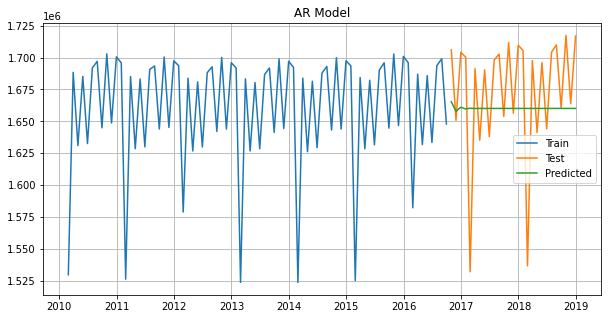

In [56]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m1,label='Predicted')
plt.title('AR Model')
plt.grid()
plt.legend()
plt.show()

In [58]:
def test_metrics(test,pred):
    mse = mean_squared_error(test,pred)
    rmse = mean_squared_error(test,pred,squared=False)
    mape = mean_absolute_percentage_error(test,pred)
    return mse,rmse,mape

In [59]:
aic_m1 = ar_m1.aic
print('AIC',aic_m1)
mse_m1,rmse_m1,mape_m1  = test_metrics(test,fcast_m1)

AIC 1935.6743909235893


In [60]:
m1_res = pd.DataFrame({'Model':'AR(1,0,0)','MSE':mse_m1,'RMSE':rmse_m1,
                       'MAPE':mape_m1,'AIC':aic_m1},index=[0])
m1_res

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",2.392626e+09,48914.47799,0.023482,1935.674391


### base MA model(0,0,1)

In [61]:
m2 = ARIMA(train,order=(0,0,1))
ar_m2 = m2.fit()
print(ar_m2.summary())

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                   80
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -965.651
Date:                Fri, 30 Dec 2022   AIC                           1937.302
Time:                        16:44:37   BIC                           1944.448
Sample:                    02-28-2010   HQIC                          1940.167
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.66e+06   3626.933    457.722      0.000    1.65e+06    1.67e+06
ma.L1         -0.4028      0.112     -3.612      0.000      -0.621      -0.184
sigma2       1.67e+09      0.009   1.86e+11      0.0

In [62]:
fcast_m2 = ar_m2.forecast(27)
fcast_m2

2016-10-31    1.657090e+06
2016-11-30    1.660129e+06
2016-12-31    1.660129e+06
2017-01-31    1.660129e+06
2017-02-28    1.660129e+06
2017-03-31    1.660129e+06
2017-04-30    1.660129e+06
2017-05-31    1.660129e+06
2017-06-30    1.660129e+06
2017-07-31    1.660129e+06
2017-08-31    1.660129e+06
2017-09-30    1.660129e+06
2017-10-31    1.660129e+06
2017-11-30    1.660129e+06
2017-12-31    1.660129e+06
2018-01-31    1.660129e+06
2018-02-28    1.660129e+06
2018-03-31    1.660129e+06
2018-04-30    1.660129e+06
2018-05-31    1.660129e+06
2018-06-30    1.660129e+06
2018-07-31    1.660129e+06
2018-08-31    1.660129e+06
2018-09-30    1.660129e+06
2018-10-31    1.660129e+06
2018-11-30    1.660129e+06
2018-12-31    1.660129e+06
Freq: M, Name: predicted_mean, dtype: float64

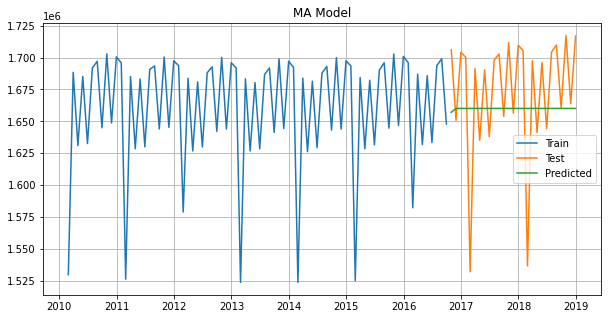

In [63]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m2,label='Predicted')
plt.title('MA Model')
plt.grid()
plt.legend()
plt.show()

In [64]:
aic_m2 = ar_m2.aic
print('AIC',aic_m2)
mse_m2,rmse_m2,mape_m2  = test_metrics(test,fcast_m2)

AIC 1937.301919641554


In [65]:
m2_res = pd.DataFrame({'Model':'MA(0,0,1)','MSE':mse_m2,'RMSE':rmse_m2,
                       'MAPE':mape_m2,'AIC':aic_m2},index=[1])
m2_res

,Model,MSE,RMSE,MAPE,AIC
1,"MA(0,0,1)",2.421412e+09,49207.847384,0.023717,1937.30192


### base ARMA model

In [66]:
m3 = ARIMA(train,order=(1,0,1))
ar_m3 = m3.fit()
print(ar_m3.summary())

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                   80
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -964.737
Date:                Fri, 30 Dec 2022   AIC                           1937.475
Time:                        16:46:14   BIC                           1947.003
Sample:                    02-28-2010   HQIC                          1941.295
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.66e+06   4020.613    412.904      0.000    1.65e+06    1.67e+06
ar.L1         -0.4181      0.296     -1.415      0.157      -0.997       0.161
ma.L1         -0.0132      0.300     -0.044      0.9

In [67]:
fcast_m3 = ar_m3.forecast(27)
fcast_m3

2016-10-31    1.665171e+06
2016-11-30    1.658020e+06
2016-12-31    1.661010e+06
2017-01-31    1.659760e+06
2017-02-28    1.660283e+06
2017-03-31    1.660064e+06
2017-04-30    1.660156e+06
2017-05-31    1.660118e+06
2017-06-30    1.660134e+06
2017-07-31    1.660127e+06
2017-08-31    1.660130e+06
2017-09-30    1.660128e+06
2017-10-31    1.660129e+06
2017-11-30    1.660129e+06
2017-12-31    1.660129e+06
2018-01-31    1.660129e+06
2018-02-28    1.660129e+06
2018-03-31    1.660129e+06
2018-04-30    1.660129e+06
2018-05-31    1.660129e+06
2018-06-30    1.660129e+06
2018-07-31    1.660129e+06
2018-08-31    1.660129e+06
2018-09-30    1.660129e+06
2018-10-31    1.660129e+06
2018-11-30    1.660129e+06
2018-12-31    1.660129e+06
Freq: M, Name: predicted_mean, dtype: float64

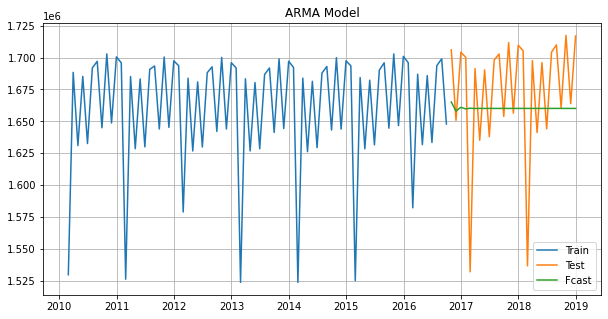

In [68]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m3,label='Fcast')
plt.title('ARMA Model')
plt.grid()
plt.legend()
plt.show()

In [69]:
aic_m3 = ar_m3.aic
print('AIC',aic_m3)
mse_m3,rmse_m3,mape_m3  = test_metrics(test,fcast_m3)

AIC 1937.4747469213758


In [70]:
m3_res = pd.DataFrame({'Model':'ARMA(1,0,1)','MSE':mse_m3,'RMSE':rmse_m3,
                       'MAPE':mape_m3,'AIC':aic_m3},index=[2])
m3_res

,Model,MSE,RMSE,MAPE,AIC
2,"ARMA(1,0,1)",2.393158e+09,48919.911627,0.023489,1937.474747


### base ARIMA(1,1,1)

In [71]:
m4 = ARIMA(train,order=(1,1,1))
ar_m4 = m4.fit()
print(ar_m4.summary())

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                   80
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1022.741
Date:                Fri, 30 Dec 2022   AIC                           2051.482
Time:                        16:48:37   BIC                           2058.590
Sample:                    02-28-2010   HQIC                          2054.330
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0888      1.088     -0.082      0.935      -2.221       2.044
ma.L1          0.0673      1.089      0.062      0.951      -2.066       2.201
sigma2      2.242e+09   3.51e-09   6.39e+17      0.0

In [72]:
fcast_m4 = ar_m4.forecast(27)
fcast_m4

2016-10-31    1.649018e+06
2016-11-30    1.648920e+06
2016-12-31    1.648929e+06
2017-01-31    1.648928e+06
2017-02-28    1.648928e+06
2017-03-31    1.648928e+06
2017-04-30    1.648928e+06
2017-05-31    1.648928e+06
2017-06-30    1.648928e+06
2017-07-31    1.648928e+06
2017-08-31    1.648928e+06
2017-09-30    1.648928e+06
2017-10-31    1.648928e+06
2017-11-30    1.648928e+06
2017-12-31    1.648928e+06
2018-01-31    1.648928e+06
2018-02-28    1.648928e+06
2018-03-31    1.648928e+06
2018-04-30    1.648928e+06
2018-05-31    1.648928e+06
2018-06-30    1.648928e+06
2018-07-31    1.648928e+06
2018-08-31    1.648928e+06
2018-09-30    1.648928e+06
2018-10-31    1.648928e+06
2018-11-30    1.648928e+06
2018-12-31    1.648928e+06
Freq: M, Name: predicted_mean, dtype: float64

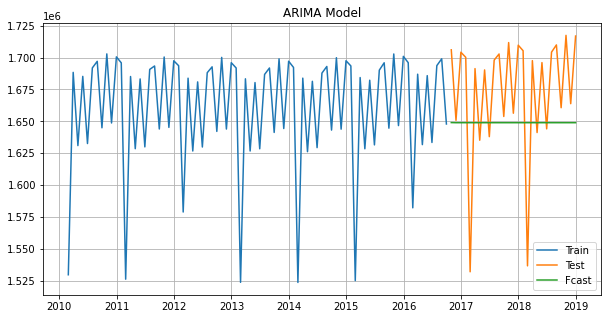

In [73]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m4,label='Fcast')
plt.title('ARIMA Model')
plt.grid()
plt.legend()
plt.show()

In [74]:
aic_m4 = ar_m4.aic
print('AIC',aic_m4)

mse_m4,rmse_m4,mape_m4  = test_metrics(test,fcast_m4)

AIC 2051.4818599255264


In [75]:
m4_res = pd.DataFrame({'Model':'ARIMA(1,1,1)','MSE':mse_m4,'RMSE':rmse_m4,
                       'MAPE':mape_m4,'AIC':aic_m4},index=[3])
m4_res

,Model,MSE,RMSE,MAPE,AIC
3,"ARIMA(1,1,1)",2.827101e+09,53170.488442,0.026373,2051.48186


### ARIMA(2,1,2)

In [76]:
m5 = ARIMA(train,order=(2,1,2))
ar_m5 = m5.fit()
print(ar_m5.summary())

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                   80
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1000.625
Date:                Fri, 30 Dec 2022   AIC                           2011.250
Time:                        16:50:56   BIC                           2023.097
Sample:                    02-28-2010   HQIC                          2015.996
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7076      0.010   -179.526      0.000      -1.726      -1.689
ar.L2         -0.9972      0.008   -124.098      0.000      -1.013      -0.981
ma.L1          1.7141      0.069     24.737      0.0

In [77]:
fcast_m5 = ar_m5.forecast(27)
fcast_m5

2016-10-31    1.686500e+06
2016-11-30    1.674148e+06
2016-12-31    1.656765e+06
2017-01-31    1.698766e+06
2017-02-28    1.644381e+06
2017-03-31    1.695362e+06
2017-04-30    1.662544e+06
2017-05-31    1.667742e+06
2017-06-30    1.691593e+06
2017-07-31    1.645682e+06
2017-08-31    1.700293e+06
2017-09-30    1.652825e+06
2017-10-31    1.679419e+06
2017-11-30    1.681345e+06
2017-12-31    1.651536e+06
2018-01-31    1.700517e+06
2018-02-28    1.646605e+06
2018-03-31    1.689817e+06
2018-04-30    1.669793e+06
2018-05-31    1.660892e+06
2018-06-30    1.696060e+06
2018-07-31    1.644886e+06
2018-08-31    1.697199e+06
2018-09-30    1.658904e+06
2018-10-31    1.672126e+06
2018-11-30    1.687737e+06
2018-12-31    1.647894e+06
Freq: M, Name: predicted_mean, dtype: float64

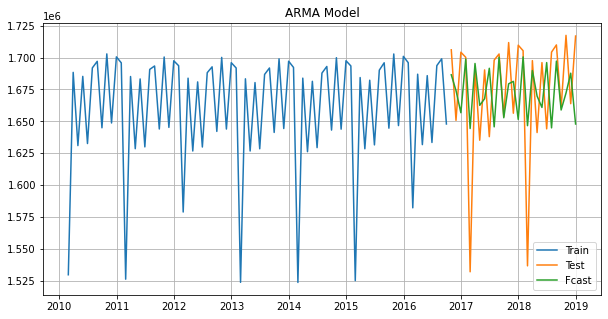

In [78]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m5,label='Fcast')
plt.title('ARMA Model')
plt.grid()
plt.legend()
plt.show()

In [79]:
aic_m5 = ar_m5.aic
print('AIC',aic_m5)

mse_m5,rmse_m5,mape_m5  = test_metrics(test,fcast_m5)

AIC 2011.249923254992


In [80]:
m5_res = pd.DataFrame({'Model':'ARIMA(2,1,2)','MSE':mse_m5,'RMSE':rmse_m5,
                       'MAPE':mape_m5,'AIC':aic_m5},index=[4])
m5_res

,Model,MSE,RMSE,MAPE,AIC
4,"ARIMA(2,1,2)",2.063577e+09,45426.614662,0.020984,2011.249923


In [81]:
def arima_model(train_data,test_data,p,d,q,fcast_val):
    model = ARIMA(train_data,order=(p,d,q))
    ar_model = model.fit()
    print(ar_model.summary())

    fcast_model = ar_model.forecast(fcast_val)
    fcast_model

    plt.figure(figsize=(10,5))
    plt.plot(train_data,label='Train')
    plt.plot(test_data,label='Test')
    plt.plot(fcast_model,label='Fcast')
#     plt.title('ARMA Model')
    plt.grid()
    plt.legend()
    plt.show()
    return ar_model,fcast_model

### ARIMA(3,1,2)

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                   80
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1000.393
Date:                Fri, 30 Dec 2022   AIC                           2012.787
Time:                        16:53:15   BIC                           2027.003
Sample:                    02-28-2010   HQIC                          2018.482
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6762      0.013   -127.129      0.000      -1.702      -1.650
ar.L2         -0.9446      0.018    -52.389      0.000      -0.980      -0.909
ar.L3          0.0312      0.010      3.135      0.0

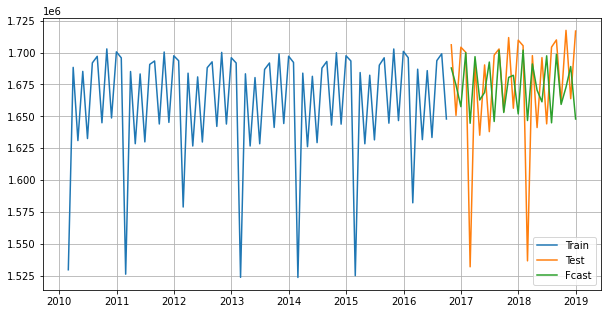

In [82]:
ar_m6,fcast_model = arima_model(train,test,p=3,d=1,q=2,fcast_val=27)

In [83]:
aic_m6 = ar_m6.aic
print('AIC',aic_m6)
mse_m6,rmse_m6,mape_m6  = test_metrics(test,fcast_model)

AIC 2012.7867204415295


In [84]:
m6_res = pd.DataFrame({'Model':'ARIMA(3,1,2)','MSE':mse_m6,'RMSE':rmse_m6,
                       'MAPE':mape_m6,'AIC':aic_m6},index=[6])
m6_res

,Model,MSE,RMSE,MAPE,AIC
6,"ARIMA(3,1,2)",2.064479e+09,45436.533822,0.020861,2012.78672


### CUSTOM ARIMA

In [86]:
p = list(range(0,8))
q = list(range(0,8))
d = list(range(0,3))

pdq = []
mse=[]
rmse=[]
for i in p:
    for j in d:
        for k in q:
            m = ARIMA(train,order=(i,j,k))
            m.initialize_approximate_diffuse()
            arima = m.fit()
            ypred=arima.forecast(27)
            mean_sq_er=mean_squared_error(test,ypred)
            pdq.append((i,j,k))
            mse.append(mean_sq_er)
print(pdq)
print(mse)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 0, 6), (1, 0, 7), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 1, 6), (1, 1, 7), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5), (2, 0, 6), (2, 0, 7), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 1, 6), (2, 1, 7), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5), (2, 2, 6), (2, 2, 7), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 0, 5), (3, 0, 6), (3, 0, 7), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 1, 5), (3, 1, 6), (3, 1, 7), (3, 2, 0), (3, 2, 1), (3, 2, 2)

In [87]:
mse_min=min(mse)
print(mse_min)
min_mse_idx=mse.index(mse_min)
print(min_mse_idx)
print(pdq[min_mse_idx])

995127400.9604735
174
(7, 0, 6)


### ARIMA(7,0,6)

In [88]:
m7=ARIMA(train,order=(7,0,6))
m7.initialize_approximate_diffuse()
ar_m7=m7.fit()
print(ar_m7.summary())

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                   80
Model:                 ARIMA(7, 0, 6)   Log Likelihood               -9422.177
Date:                Fri, 30 Dec 2022   AIC                          18874.354
Time:                        16:58:29   BIC                          18910.084
Sample:                    02-28-2010   HQIC                         18888.679
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.66e+06      7.670   2.16e+05      0.000    1.66e+06    1.66e+06
ar.L1         -0.4669      0.142     -3.284      0.001      -0.746      -0.188
ar.L2          0.0178      0.101      0.177      0.8

In [89]:
fcast_m2=ar_m2.forecast(27)
fcast_m2

2016-10-31    1.657090e+06
2016-11-30    1.660129e+06
2016-12-31    1.660129e+06
2017-01-31    1.660129e+06
2017-02-28    1.660129e+06
2017-03-31    1.660129e+06
2017-04-30    1.660129e+06
2017-05-31    1.660129e+06
2017-06-30    1.660129e+06
2017-07-31    1.660129e+06
2017-08-31    1.660129e+06
2017-09-30    1.660129e+06
2017-10-31    1.660129e+06
2017-11-30    1.660129e+06
2017-12-31    1.660129e+06
2018-01-31    1.660129e+06
2018-02-28    1.660129e+06
2018-03-31    1.660129e+06
2018-04-30    1.660129e+06
2018-05-31    1.660129e+06
2018-06-30    1.660129e+06
2018-07-31    1.660129e+06
2018-08-31    1.660129e+06
2018-09-30    1.660129e+06
2018-10-31    1.660129e+06
2018-11-30    1.660129e+06
2018-12-31    1.660129e+06
Freq: M, Name: predicted_mean, dtype: float64

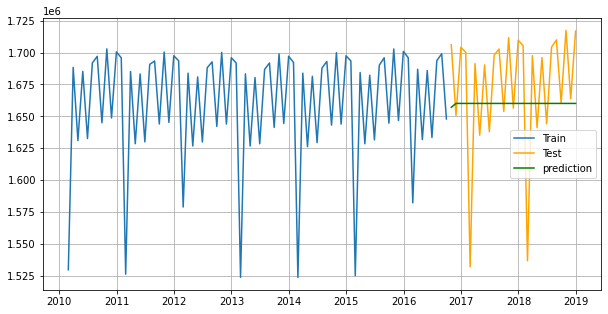

In [90]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test',color='orange')
plt.plot(fcast_m2,label='prediction',color='green')

plt.grid()
plt.legend()
plt.show()

In [96]:
aic_m7=ar_m7.aic
print(aic_m7)
mse_m7,rmse_m7,mape_m7=test_metrics(test,fcast_m2)
print('MSE_m7',mse_m7,'RMSE_m7',rmse_m7)

18874.35396931402
MSE_m7 2421412244.1644917 RMSE_m7 49207.84738397415


In [97]:
m7_res = pd.DataFrame({'Model':'ARIMA(7,0,6)','MSE':mse_m7,'RMSE':rmse_m7,
                       'MAPE':mape_m7,'AIC':aic_m7},index=[7])
m7_res

,Model,MSE,RMSE,MAPE,AIC
7,"ARIMA(7,0,6)",2.421412e+09,49207.847384,0.023717,18874.353969


### PMDARIMA

In [102]:
import pmdarima as pm

In [103]:
m10 = pm.auto_arima(train,start_p=0,start_q=0,
              test='adf',
              d=None,                     # use adftest to find optimal 'd'        
              max_p=3,max_q=3,max_d=1,
              start_P=0,start_Q=0,
              D=0,                       # enforcing D=0
              max_P=3,max_Q=3,
              seasonal=True,
              trace=True,
              suppress_warnings=True, 
              stepwise=True)  

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1947.968, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1935.804, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1937.533, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2520.676, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1937.608, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1937.568, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1939.483, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.970 seconds


In [104]:
fcast_m10 = m10.predict(27)
fcast_m10

2016-10-31    1.665570e+06
2016-11-30    1.658663e+06
2016-12-31    1.661366e+06
2017-01-31    1.660308e+06
2017-02-28    1.660722e+06
2017-03-31    1.660560e+06
2017-04-30    1.660623e+06
2017-05-31    1.660599e+06
2017-06-30    1.660608e+06
2017-07-31    1.660605e+06
2017-08-31    1.660606e+06
2017-09-30    1.660605e+06
2017-10-31    1.660606e+06
2017-11-30    1.660606e+06
2017-12-31    1.660606e+06
2018-01-31    1.660606e+06
2018-02-28    1.660606e+06
2018-03-31    1.660606e+06
2018-04-30    1.660606e+06
2018-05-31    1.660606e+06
2018-06-30    1.660606e+06
2018-07-31    1.660606e+06
2018-08-31    1.660606e+06
2018-09-30    1.660606e+06
2018-10-31    1.660606e+06
2018-11-30    1.660606e+06
2018-12-31    1.660606e+06
Freq: M, dtype: float64

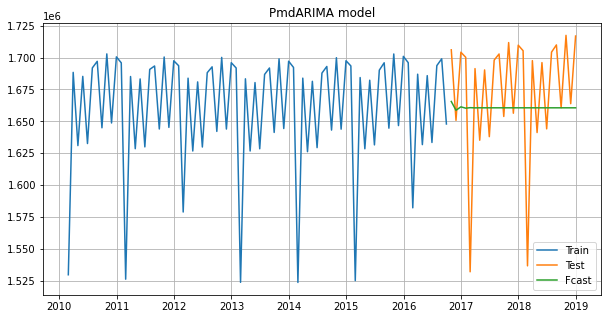

In [106]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(fcast_m10,label='Fcast')
plt.title('PmdARIMA model')
plt.grid()
plt.legend()
plt.show()

In [107]:
aic_m10 = m10.aic()
print('AIC',aic_m10)
mse_m10,rmse_m10,mape_m10  = test_metrics(test,fcast_m10)

AIC 1935.8036861049613


In [108]:
m10_res = pd.DataFrame({'Model':'PmdARIMA','MSE':mse_m10,'RMSE':rmse_m10,
                       'MAPE':mape_m10,'AIC':aic_m10},index=[10])
m10_res

,Model,MSE,RMSE,MAPE,AIC
10,PmdARIMA,2.381181e+09,48797.346391,0.023405,1935.803686


In [109]:
re=[m1_res,m2_res,m3_res,m4_res,m5_res,m6_res,m7_res,m10_res]
res=pd.concat(re)
res

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",2.392626e+09,48914.477990,0.023482,1935.674391
1,"MA(0,0,1)",2.421412e+09,49207.847384,0.023717,1937.301920
2,"ARMA(1,0,1)",2.393158e+09,48919.911627,0.023489,1937.474747
3,"ARIMA(1,1,1)",2.827101e+09,53170.488442,0.026373,2051.481860
4,"ARIMA(2,1,2)",2.063577e+09,45426.614662,0.020984,2011.249923
6,"ARIMA(3,1,2)",2.064479e+09,45436.533822,0.020861,2012.786720
7,"ARIMA(7,0,6)",2.421412e+09,49207.847384,0.023717,18874.353969
10,PmdARIMA,2.381181e+09,48797.346391,0.023405,1935.803686


In [111]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### smoothing

In [115]:
alpha=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
beta=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

abg=[]
mse_es=[]
for i in alpha :
    for j in beta:
        for k in gamma:
            es=ExponentialSmoothing(train)
            es_model=es.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k)
            ypred=es_model.forecast(27)
            mean_sq_er=mean_squared_error(test,ypred)
            abg.append((i,j,k))
            mse_es.append(mean_sq_er)

In [116]:
print(len(mse_es))
min_mse=min(mse_es)
print(min_mse)
index=mse_es.index(min_mse)
print(index)
print(abg[index])

729
2271983359.474276
243
(0.4, 0.1, 0.1)


In [121]:
alpha=0.4
beta = 0.1
gamma=0.1
m11 = ExponentialSmoothing(train)
tes_m11 = m11.fit(smoothing_level=alpha,smoothing_trend=beta,smoothing_seasonal=gamma)
print(tes_m11.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:              number_sold   No. Observations:                   80
Model:             ExponentialSmoothing   SSE                   234229393178.328
Optimized:                         True   AIC                           1747.803
Trend:                             None   BIC                           1752.567
Seasonal:                          None   AICC                          1748.337
Seasonal Periods:                  None   Date:                 Fri, 30 Dec 2022
Box-Cox:                          False   Time:                         17:29:46
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.4000000                alpha                False
initial_level              1.613e+

In [122]:
fcast_m11 = tes_m11.forecast(27)
fcast_m11

2016-10-31    1.667623e+06
2016-11-30    1.667623e+06
2016-12-31    1.667623e+06
2017-01-31    1.667623e+06
2017-02-28    1.667623e+06
2017-03-31    1.667623e+06
2017-04-30    1.667623e+06
2017-05-31    1.667623e+06
2017-06-30    1.667623e+06
2017-07-31    1.667623e+06
2017-08-31    1.667623e+06
2017-09-30    1.667623e+06
2017-10-31    1.667623e+06
2017-11-30    1.667623e+06
2017-12-31    1.667623e+06
2018-01-31    1.667623e+06
2018-02-28    1.667623e+06
2018-03-31    1.667623e+06
2018-04-30    1.667623e+06
2018-05-31    1.667623e+06
2018-06-30    1.667623e+06
2018-07-31    1.667623e+06
2018-08-31    1.667623e+06
2018-09-30    1.667623e+06
2018-10-31    1.667623e+06
2018-11-30    1.667623e+06
2018-12-31    1.667623e+06
Freq: M, dtype: float64

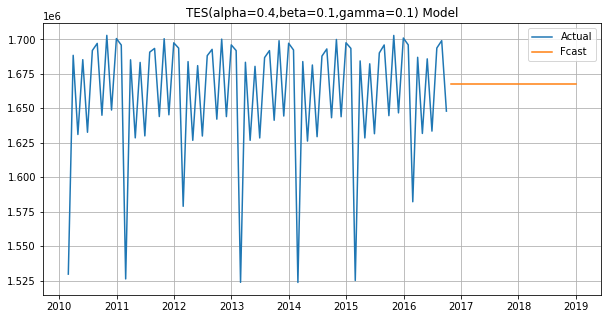

In [120]:
plt.figure(figsize=(10,5))
plt.plot(train,label='Actual')
plt.plot(fcast_m11,label='Fcast')
plt.title('TES(alpha=0.4,beta=0.1,gamma=0.1) Model')
plt.grid()
plt.legend()
plt.show()

In [127]:
res

,Model,MSE,RMSE,MAPE,AIC
0,"AR(1,0,0)",2.392626e+09,48914.477990,0.023482,1935.674391
1,"MA(0,0,1)",2.421412e+09,49207.847384,0.023717,1937.301920
2,"ARMA(1,0,1)",2.393158e+09,48919.911627,0.023489,1937.474747
3,"ARIMA(1,1,1)",2.827101e+09,53170.488442,0.026373,2051.481860
4,"ARIMA(2,1,2)",2.063577e+09,45426.614662,0.020984,2011.249923
6,"ARIMA(3,1,2)",2.064479e+09,45436.533822,0.020861,2012.786720
7,"ARIMA(7,0,6)",2.421412e+09,49207.847384,0.023717,18874.353969
10,PmdARIMA,2.381181e+09,48797.346391,0.023405,1935.803686


##### based on RMSE ARIMA(2,1,2) is the best model